# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#Tracking experiments
%pip install -q wandb
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37774535.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1097313.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9254826.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12426959.41it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
len(ds_train)

55000

In [ ]:
len(ds_val), len(ds_test)

(5000, 10000)

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [3]:
from tqdm import tqdm #smart progress meter for loops
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    #Make sure model is in training
    model.train() #per salvare i gradienti, sennò non funziona backProp

    #capture all batch loss
    losses = []

    #iterate over all batches in dataloader
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device) #move images and labels to desired device
        ys = ys.to(device)
        opt.zero_grad() #zero out gradients
        logits = model(xs) #forward pass

        #Hardcoded cross-entropy loss
        loss = F.cross_entropy(logits, ys)

        #compute gradients
        loss.backward()

        #update parameters
        opt.step()

        #Save current batch loss
        losses.append(loss.item())

    #return average loss for this batch
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())

    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [ ]:
#Simple parametrized MLP. Argument layer_sizes provides sizes of all layers
#Obfuscated to encourage you to write your own
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])

    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 99: 100%|█████████████████████████████████████████████████████████████| 430/430 [00:23<00:00, 18.20it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.963     0.984     0.973       980
           1      0.972     0.981     0.977      1135
           2      0.961     0.950     0.955      1032
           3      0.933     0.948     0.940      1010
           4      0.938     0.956     0.947       982
           5      0.936     0.927     0.931       892
           6      0.955     0.957     0.956       958
           7      0.950     0.940     0.945      1028
           8      0.941     0.925     0.933       974
           9      0.942     0.922     0.932      1009

    accuracy                          0.950     10000
   macro avg      0.949     0.949     0.949     10000
weighted avg      0.949     0.950     0.949     10000



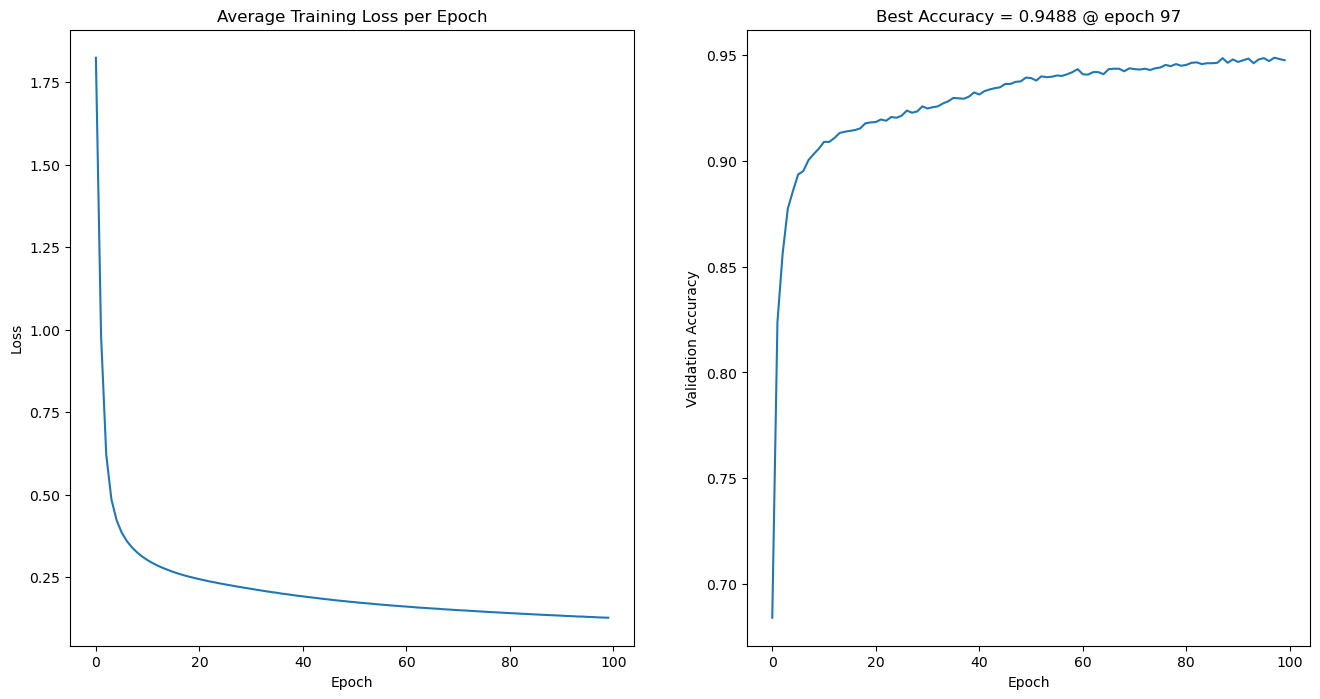

In [ ]:
# Training hyperparameters.
device = 'cuda' #cuda se su collab
epochs = 100
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size = 784, output_size = 10, layers = [32, 32]):
        super().__init__()

        self.first_layer = nn.Linear(input_size, layers[0])
        self.inner_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.last_layer = nn.Linear(layers[-1], output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.first_layer(x))
        for layer in self.inner_layers:
            x = F.relu(layer(x))
        x = self.last_layer(x)
        return x

#ricordarsi di fare flatten quando si passano le immagini

In [ ]:
model = MultiLayerPerceptron(layers = [32, 32, 32])
model

MultiLayerPerceptron(
  (first_layer): Linear(in_features=784, out_features=32, bias=True)
  (inner_layers): ModuleList(
    (0-1): 2 x Linear(in_features=32, out_features=32, bias=True)
  )
  (last_layer): Linear(in_features=32, out_features=10, bias=True)
)

In [4]:
#Trainig loop
def train(model, optimizer, dl_train, criterion, epoch, device = 'cuda'):
    model.train()
    train_losses = []
    trn_corr = 0

    for b, (x_train, y_train) in enumerate(dl_train):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1] #Prediction with maximum probability
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if b%300 == 0:
            print(f'epoch: {epoch:2} batch{b:4} [{100*b:6}] Train loss: {loss.item():10.8f} Train accuracy: {batch_corr.item()*100/len(y_train):.3f}%')

        return (np.mean(train_losses), trn_corr)

In [5]:
#Validation
#TODO metti loss per vedere overfitting FATTO
def evaluate(model, dl_val, val_size, criterion, device = 'cuda'):
    model.eval()
    val_corr = 0

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for b, (x_val, y_val) in enumerate(dl_val):
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_pred = model(x_val)
            loss_val = criterion(y_pred, y_val)

            predicted = torch.max(y_pred.data, 1)[1]
            val_corr += (predicted == y_val).sum()

    val_accuracy = val_corr / val_size

    return (loss_val, val_accuracy)

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
dataset_train = MNIST(root='./data', train=True, download=True, transform=transform) #60000 images
ds_test = MNIST(root='./data', train=False, download=True, transform=transform) #10000 images

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4495869.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 131544.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1193903.71it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4844997.14it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#track run
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"MLP",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "MLP",
    "dataset": "mnist",
    "epochs": 10,
    "batch_size": 128,
    "validation_set_size": 5000,
    "layers"= [32, 32, 32]})

# Split train into train and validation.
ds_train, ds_val = torch.utils.data.random_split(dataset_train, [60000 - run.config["validation_set_size"], run.config["validation_set_size"]])

dl_train = torch.utils.data.DataLoader(ds_train, run.config["batch_size"], shuffle=True, num_workers=2)
dl_val   = torch.utils.data.DataLoader(ds_val, run.config["batch_size"], num_workers=2)
dl_test  = torch.utils.data.DataLoader(ds_test, run.config["batch_size"], shuffle=True, num_workers=2)

#Training and Test
#TODO salvare modello con accuracy migliore, usare state_dict() e load_state_dict() FATTO
#TODO wandb wandb.Artifact()
device = 'cuda'

modelMLP = MultiLayerPerceptron(layers = run.config["layers"]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=run.config["learning_rate"])

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    (train_loss, train_corr) = train(modelMLP, optimizer, dl_train, criterion, epoch)
    train_accuracy = (train_corr / (60000 - run.config["validation_set_size"])) * 100
    metrics = {"train_loss": train_loss,
               "train_accuracy": train_accuracy}

    (validation_loss, validation_accuracy) = evaluate(modelMLP, dl_val, run.config["validation_set_size"], criterion)
    if validation_accuracy >= best_accuracy:
        state_dict = modelMLP.state_dict()
    val_metrics = {"validation_loss": validation_loss,
                   "validation_accuracy": validation_accuracy}

    wandb.log({**metrics, **val_metrics})

#Test
modelMLP.load_state_dict(state_dict)

#save model on weights and biases
model_artifact = wandb.Artifact(
    "MLP", type="model",
    ddescription="best model",
    metadata=dict(run.config))

torch.save(modelMLP.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

(_, test_accuracy) = evaluate(modelMLP, dl_test, 10000, criterion) #TODO usare modello con migliore validation_accuracy FATTO
#TODO usare solo un log, rendere in uscita metriche di interesse FATTO

print(f'Accuracy report on TEST: {test_accuracy*100}%')
wandb.summary['Test Accuracy'] = test_accuracy #fare log

wandb.finish()

epoch:  0 batch   0 [     0] Train loss: 2.31506109 Train accuracy: 4.000%
epoch:  1 batch   0 [     0] Train loss: 2.29920220 Train accuracy: 12.000%
epoch:  2 batch   0 [     0] Train loss: 2.27284932 Train accuracy: 10.000%
epoch:  3 batch   0 [     0] Train loss: 2.31315231 Train accuracy: 7.000%
epoch:  4 batch   0 [     0] Train loss: 2.28573823 Train accuracy: 9.000%
epoch:  5 batch   0 [     0] Train loss: 2.25199223 Train accuracy: 10.000%
epoch:  6 batch   0 [     0] Train loss: 2.25789285 Train accuracy: 9.000%
epoch:  7 batch   0 [     0] Train loss: 2.23910785 Train accuracy: 17.000%
epoch:  8 batch   0 [     0] Train loss: 2.20770240 Train accuracy: 22.000%
epoch:  9 batch   0 [     0] Train loss: 2.21056867 Train accuracy: 27.000%


NameError: name 'ENTITY' is not defined

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [7]:
import torchvision
#load CIFAR-10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
ds_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#TODO pensare se aggiungere trasformazioni, in caso controllare che testing abbia solo normalize
#TODO mettere confusion matrix?
#TODO guardare resnet FATTO
#TODO pensare se usare learning_rate scheduler

100%|██████████| 170498071/170498071 [00:01<00:00, 90203127.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [23]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, size = 3, stride = 1, groups = 1, base_width = 64, padding = 1, residual=False):
        super().__init__()
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=size, stride=stride, padding=padding)
        self.stride = stride
        self.residual = residual

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)

        if self.residual:
            x += identity
        x = self.relu(x)

        return x

#layers: numero di blocchi per ogni layer
class CNN(nn.Module):
    def __init__(self, layers, num_classes = 10, groups = 1, width_per_group = 64, residual=False):
        super().__init__()

        self.residual = residual
        self.inplanes = 64
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, layers[0])
        self.layer2 = self.make_layer(128, layers[1], stride=2)
        #self.layer3 = self.make_layer(256, layers[2], stride=2)
        #self.layer4 = self.make_layer(512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, planes, blocks, stride = 1):

        layers = []
        layers.append(BasicBlock(self.inplanes, planes, stride=stride, groups=self.groups, base_width=self.base_width, residual=self.residual))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.inplanes, planes, groups=self.groups, base_width=self.base_width, residual=self.residual))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        #x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [29]:
#track run
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Final",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"MLP",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-2,
    "architecture": "CNN",
    "dataset": "Cifar10",
    "epochs": 200,
    "batch_size": 128,
    "validation_set_size": 5000}) #TODO aggiungere depth

#Split into train and validation
ds_train, ds_val = torch.utils.data.random_split(trainset, [50000 - run.config["validation_set_size"], run.config["validation_set_size"]])

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True, num_workers=2)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"], num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False, num_workers=2)

#Training and Test
device = 'cuda'

modelCNN = CNN(layers=[1,1,1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=run.config["learning_rate"])

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    (train_loss, train_corr) = train(modelCNN, optimizer, dl_train, criterion, epoch)
    train_accuracy = (train_corr / (60000 - run.config["validation_set_size"])) * 100
    metrics = {"train_loss": train_loss,
               "train_accuracy": train_accuracy}

    (validation_loss, validation_accuracy) = evaluate(modelCNN, dl_val, run.config["validation_set_size"], criterion)
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNN.state_dict()
    val_metrics = {"validation_loss": validation_loss,
                   "validation_accuracy": validation_accuracy}

    wandb.log({**metrics, **val_metrics})

#Test
modelCNN.load_state_dict(state_dict)

#save model on weights and biases
model_artifact = wandb.Artifact(
    "CNN", type="model",
    description="best model",
    metadata=dict(run.config))

torch.save(modelCNN.state_dict(), "best_model_cnn.pth")
model_artifact.add_file("best_model_cnn.pth")
wandb.save("best_model_cnn.pth")
run.log_artifact(model_artifact)

(_, test_accuracy) = evaluate(modelCNN, dl_test, 10000, criterion) #TODO usare modello con migliore validation_accuracy FATTO
#TODO usare solo un log, rendere in uscita metriche di interesse FATTO

print(f'Accuracy report on TEST: {test_accuracy*100}%')
wandb.summary['Test Accuracy'] = test_accuracy #TODO usare log

wandb.finish()

epoch:  0 batch   0 [     0] Train loss: 2.31158757 Train accuracy: 10.156%
epoch:  1 batch   0 [     0] Train loss: 7.06790066 Train accuracy: 12.500%
epoch:  2 batch   0 [     0] Train loss: 2.30244732 Train accuracy: 7.812%
epoch:  3 batch   0 [     0] Train loss: 2.32797623 Train accuracy: 7.812%
epoch:  4 batch   0 [     0] Train loss: 2.29500461 Train accuracy: 10.938%
epoch:  5 batch   0 [     0] Train loss: 2.30050850 Train accuracy: 14.844%
epoch:  6 batch   0 [     0] Train loss: 2.30743933 Train accuracy: 10.156%
epoch:  7 batch   0 [     0] Train loss: 2.30326462 Train accuracy: 10.938%
epoch:  8 batch   0 [     0] Train loss: 2.29633307 Train accuracy: 7.031%
epoch:  9 batch   0 [     0] Train loss: 2.29434299 Train accuracy: 13.281%
epoch: 10 batch   0 [     0] Train loss: 2.23167062 Train accuracy: 15.625%
epoch: 11 batch   0 [     0] Train loss: 2.25400567 Train accuracy: 12.500%
epoch: 12 batch   0 [     0] Train loss: 2.29116940 Train accuracy: 12.500%
epoch: 13 batch

train_accuracy,▂▃▂▁▂▃▄▄▅▃▅▆▄▄▅▆▅▄▄▆▅▇▆▇▅▅▆▇▇▆▆▆▇▆▆█▇▆▆▆
train_loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▂▁▃▄▄▄▄▄▅▅▆▅▆▅▆▆▆▆▆▆▆▆▅▇▇▆▇▇▇██▇██████
validation_loss,███▇█▆▆▆▇▇▅▆▆▅▅▅▂▄▅▄▄▄▅▅▅▆▇▄▅▅█▃▅▅▅▆▃▅▄▁
Test Accuracy,0.3455
train_accuracy,0.08
train_loss,1.79659
validation_accuracy,0.3456
validation_loss,1.62663


In [ ]:
#RESIDUAL

#track run
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"ResidualCNN",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-2,
    "architecture": "ResidualCNN",
    "dataset": "Cifar10",
    "epochs": 200,
    "batch_size": 128,
    "validation_set_size": 5000}) #TODO aggiungere depth

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch-size"], shuffle=True, num_workers=2)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch-size"], num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch-size"], shuffle=False, num_workers=2)

#Training and Test
device = 'cuda'

modelCNN = CNN(layers=[1, 1, 1], residual=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=run.config["learning_rate"])

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    (train_loss, train_corr) = train(modelCNN, optimizer, dl_train, criterion, epoch)
    train_accuracy = (train_corr / (60000 - run.config["validation_set_size"])) * 100
    metrics = {"train_loss": train_loss,
               "train_accuracy": train_accuracy}

    (validation_loss, validation_accuracy) = evaluate(modelCNN, dl_val, run.config["validation_set_size"], criterion)
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNN.state_dict()
    val_metrics = {"validation_loss": validation_loss,
                   "validation_accuracy": validation_accuracy}

    wandb.log({**metrics, **val_metrics})

#Test
modelCNN.load_state_dict(state_dict)

#save model on weights and biases
model_artifact = wandb.Artifact(
    "ResidualCNN", type="model",
    ddescription="best model",
    metadata=dict(run.config))

torch.save(modelMLP.state_dict(), "best_model_rcnn.pth")
model_artifact.add_file("best_model_rcnn.pth")
wandb.save("best_model_rcnn.pth")
run.log_artifact(model_artifact)

(_, test_accuracy) = evaluate(modelMLP, dl_test, 10000, criterion) #TODO usare modello con migliore validation_accuracy FATTO
#TODO usare solo un log, rendere in uscita metriche di interesse FATTO

print(f'Accuracy report on TEST: {test_accuracy*100}%')
wandb.summary['Test Accuracy'] = test_accuracy

wandb.finish()

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [ ]:
# Your code here.

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

In [ ]:
# Your code here.